# Analyzing impact of the Pandemic in NYC Residences Prices

### Data Cleaning for NYC Real Estate dataset

We pulled the data from three boroughs (Manhattan, Brooklyn and Queens) over four years 2018-2021.

The variables are:

|Variable|Definition|
|:---------|:-----------|
|Borough|Number representing the borough in which the sale took place <br>
||1 = Manhattan <br>
||3 = Brooklyn <br>
||4 = Queens |
|Neighborhood| Name of neighborhood in which the sale took place|
|Building Class Category| Broad category of building class (eg. one family, multi family)|
|BLOCK| A tax block is a subdivision of the borough|
|Lot| A tax lot is a subdivision of a tax block. Distinguishes condos in the same building|
|ADDRESS| Street address of the property|
|APARTMENTNUMBER| Apartment number of the property if applicable|
|ZIPCODE| Property's postal code|
|RESIDENTIALUNITS| Number of residential units at the listed property|
|COMMERCIALUNITS| The number of commercial units at the listed property|
|TOTALUNITS| The total number of units at the listed property|
|LANDSQUAREFEET| The land area of the property list in square feet|
|GROSSSQUAREFEET| The total area of all the floors of a building as measured from the exterior surfaces of the outside walls of the building, including the land area and space within any building or structure on the property. |
|YEARBUILT| Year the structure on the property was built|
|TAXCLASSATTIMEOFSALE| - Class 1: Includes most residential property of up to three units, vacant land that is zoned for residential use, and most condominiums that are not more than three stories. <br>
||- Class 2: Includes all other property that is primarily residential, such as cooperatives and condominiums. <br>
||- Class 3: Includes property with equipment owned by a gas, telephone or electric company. <br>
||- Class 4: Includes all other properties not included in class 1,2, and 3, such as offices, factories, warehouses, garage buildings, etc.  |
|BUILDINGCLASSATTIMEOFSALE|The Building Classification is used to describe a property’s constructive use.<br>
||The Letter describes a general class of properties (for example “A” signifies one-family homes, “O” signifies office buildings. “R” signifies condominiums).<br>
||The Number adds more specific information about the property’s use or construction style (using our previous examples “A0” is a Cape Cod style one family home, “O4” is a tower type office building and “R5” is a commercial condominium unit). <br>
||https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html|
|SALEPRICE| Price paid for the property|
|SALEDATE| Date the property sold|

### Overarching Question:

We hypothesize that the housing factors that are relevant to residential buildings are mostly impacted by the pandemic due to families having to look homes to quarantine long periods, therefore we want to...

Analyze the highest average (mean) sale price of each borough (Manhattan, Brooklyn, Queens) pre Covid (2018-219) and post Covid (2020-2022) in order to identify residential relevant housing factors such as:


*   gross square feet
*   building class category (e.g one family, multi family, etc)
*   tax class at time sale: class '2' (residential property)
*   building class at time of sale 'A' (one-family home) 
*   market cap (dollar amount volume of the transaction's sale price)

that effect the housing market from the mandatory Covid quarantine policy.



Overall, did Covid changed people's preference regarding these certain housing factors, due to the inevitable quarantine lifestyle?







In [ ]:
# Import necessary libraries
import pandas as pd 
import numpy as np

# Import plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

import statsmodels.formula.api as smf

In [ ]:
# Create loop to process the datasets

# Defining lists of years and boroughs
years = [2018, 2019, 2020, 2021]
boroughs = ['manhattan', 'brooklyn', 'queens']

# Defining the list of columns we want to keep in our final database
columns_to_keep = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'BLOCK', 'LOT', 'EASE-MENT',
                    'ADDRESS', 'APARTMENTNUMBER', 'ZIPCODE', 'RESIDENTIALUNITS', 'COMMERCIALUNITS', 
                   'TOTALUNITS', 'LANDSQUAREFEET', 'GROSSSQUAREFEET', 'YEARBUILT', 'TAXCLASSATTIMEOFSALE', 
                   'BUILDINGCLASSATTIMEOFSALE', 'SALEPRICE', 'SALEDATE']

# Creating a dictionary to store the clean databases
dict_df = {}

# LOOP

for year in years :
    for borough in boroughs :

        # Importing the database
        filename = str(year) + '_' + borough + '.xlsx'

        # Load year 2018 and 2019 
        if year == 2018 or year == 2019 :
            database = pd.read_excel(filename, header = 4)
        # Load year 2020 and 2021
        elif year == 2020 or year == 2021 :
            database = pd.read_excel(filename, header = 6)
        
        # Deleting '\n's and empty spaces from column names
        database.columns = database.columns.str.replace(pat = '\n', repl = '')
        database.columns = database.columns.str.replace(pat = ' ', repl = '')
        
        # Only keeping useful columns in the db
        database = database[columns_to_keep]
        
        # Storing clean database into the dictionary
        dict_df[filename[:-5]] = database


In [ ]:
# Concatenating all clean databases into one big DB
nyc_db = pd.concat(dict_df, ignore_index = True)

# Dropping "EASE-MENT" column
nyc_db = nyc_db.drop('EASE-MENT', axis = 1)

# Putting all the right column types

nyc_db['BOROUGH'] = nyc_db['BOROUGH'].astype(str)
nyc_db['BLOCK'] = nyc_db['BLOCK'].astype(str)
nyc_db['LOT'] = nyc_db['LOT'].astype(str)
nyc_db['ZIPCODE'] = nyc_db['ZIPCODE'].astype(str)
nyc_db['TAXCLASSATTIMEOFSALE'] =nyc_db['TAXCLASSATTIMEOFSALE'].astype(str)
nyc_db['YEARBUILT'] = nyc_db['YEARBUILT'].astype(str)

# Converting the 'YEAR BUILT' column to datetime format

nyc_db['YEARBUILT'] = nyc_db['YEARBUILT'].str[0:4]
nyc_db['YEARBUILT'] = pd.to_datetime(nyc_db['YEARBUILT'], format = '%Y', errors='coerce')

# Drop rows where we do not have information on gross feet squarage and sale price
nyc_db.dropna(subset = ['SALEPRICE'], inplace = True)
nyc_db.dropna(subset = ['GROSSSQUAREFEET'], inplace = True)

# Create column with the sale year
nyc_db['saleyear'] = nyc_db['SALEDATE'].dt.year

nyc_db_subset = nyc_db.copy()

In [ ]:
# Map 2018-2019 and 2020-2021 to pre and post-Covid
nyc_db_subset['Pre/Post Covid'] = nyc_db_subset['saleyear'].map({2018 : 'Pre Covid', 2019 : 'Pre Covid', 2020 : 'Post Covid', 2021 : 'Post Covid'})

# Map Borough numbers to Boroughs names
nyc_db_subset['BOROUGH'] = nyc_db_subset['BOROUGH'].map({'1.0' : 'Manhattan', 
                                                         '3.0' : 'Brooklyn', 
                                                         '4.0' : 'Queens'})
# Cleaning NaN values from Apartment number column

nyc_db_subset.dropna(subset = ['APARTMENTNUMBER', 'BOROUGH', 'YEARBUILT'], axis = 0, inplace = True)
nyc_db_subset.drop(nyc_db_subset[nyc_db_subset['SALEPRICE'] == 0].index, inplace = True)

nyc_db_subset

,BOROUGH,NEIGHBORHOOD,BUILDINGCLASSCATEGORY,BLOCK,LOT,ADDRESS,APARTMENTNUMBER,ZIPCODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTALUNITS,LANDSQUAREFEET,GROSSSQUAREFEET,YEARBUILT,TAXCLASSATTIMEOFSALE,BUILDINGCLASSATTIMEOFSALE,SALEPRICE,SALEDATE,saleyear,Pre/Post Covid
132,Manhattan,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,378.0,1004.0,399 EAST 8TH STREET,2B,10009.0,1.00,0.00,1.00,0.00,481.00,2014-01-01,2.0,R4,"732,376.00",2018-07-25,2018,Pre Covid
133,Manhattan,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,378.0,1010.0,399 EAST 8TH STREET,3D,10009.0,1.00,0.00,1.00,0.00,733.00,2014-01-01,2.0,R4,"1,016,213.00",2018-10-09,2018,Pre Covid
134,Manhattan,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,392.0,1023.0,143 AVENUE B,6B,10009.0,1.00,0.00,1.00,"6,442.00",640.00,1928-01-01,2.0,R4,"33,159.00",2018-09-18,2018,Pre Covid
135,Manhattan,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,392.0,1061.0,143 AVENUE B,11E,10009.0,1.00,0.00,1.00,"6,442.00",500.00,1928-01-01,2.0,R4,"975,000.00",2018-06-04,2018,Pre Covid
136,Manhattan,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,392.0,1069.0,143 AVENUE B,12F,10009.0,1.00,0.00,1.00,"6,442.00",420.00,1928-01-01,2.0,R4,"680,000.00",2018-02-08,2018,Pre Covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223738,Brooklyn,DOWNTOWN-FULTON MALL,11 SPECIAL CONDO BILLING LOTS,149.0,1102.0,"138 WILLOUGHBY STREET, 68C",RESI,11201.0,458.00,0.00,458.00,"21,474.00","472,115.00",2017-01-01,2.0,RR,"2,643,434.00",2021-03-11,2021,Post Covid
223739,Brooklyn,DOWNTOWN-FULTON MALL,11 SPECIAL CONDO BILLING LOTS,149.0,1102.0,"138 WILLOUGHBY STREET, 68H",RESI,11201.0,458.00,0.00,458.00,"21,474.00","472,115.00",2017-01-01,2.0,RR,"2,625,994.00",2021-10-07,2021,Post Covid
226481,Brooklyn,FLATBUSH-CENTRAL,11 SPECIAL CONDO BILLING LOTS,5141.0,1102.0,"1027 CORTELYOU ROAD, R1",R1,11218.0,11.00,0.00,11.00,"5,111.00","13,744.00",2019-01-01,2.0,RR,"12,835,000.00",2021-12-21,2021,Post Covid
238910,Brooklyn,WILLIAMSBURG-EAST,11 SPECIAL CONDO BILLING LOTS,2765.0,1007.0,"764 METROPOLITAN AVENUE, 4A",4A,11211.0,1.00,0.00,1.00,0.00,"1,460.00",2015-01-01,2.0,RR,"1,612,500.00",2021-06-07,2021,Post Covid


### Descriptive Question #1: 

Since we assume that sale price fluctuation would happen from residential units that are affected by the quarantine rule, we decided to use tax class type 2 under the residential transaction variable. 


What percentage of the total residential transactions (Tax Class Type Two) occured before and after the pandemic? How does this vary across the different boroughs?





In [ ]:
# Create Data Frame for Tax Class 2 Properties
class2 = nyc_db_subset.loc[nyc_db_subset['TAXCLASSATTIMEOFSALE'] == '2.0']
#Include Pre Covid Variables
class2.pre = class2.loc[class2['Pre/Post Covid'] == 'Pre Covid']

# Find number of transactions for each borough
class2.pre.manhattan = class2.pre.loc[class2.pre['BOROUGH'] == 'Manhattan']
class2.pre.brooklyn = class2.pre.loc[class2.pre['BOROUGH'] == 'Brooklyn']
class2.pre.queens = class2.pre.loc[class2.pre['BOROUGH'] == 'Queens']

#Include Post Covid Variables
class2.post = class2.loc[class2['Pre/Post Covid'] == 'Post Covid']

# Find number of transactions for each borough
class2.post.manhattan = class2.post.loc[class2.post['BOROUGH'] == 'Manhattan']
class2.post.brooklyn = class2.post.loc[class2.post['BOROUGH'] == 'Brooklyn']
class2.post.queens = class2.post.loc[class2.post['BOROUGH'] == 'Queens']



preman = class2.pre.manhattan.BOROUGH.count()/class2.BOROUGH.count()
prebro = class2.pre.brooklyn.BOROUGH.count()/class2.BOROUGH.count()
preque = class2.pre.queens.BOROUGH.count()/class2.BOROUGH.count()
postman = class2.post.manhattan.BOROUGH.count()/class2.BOROUGH.count()
postbro = class2.post.brooklyn.BOROUGH.count()/class2.BOROUGH.count()
postque = class2.post.queens.BOROUGH.count()/class2.BOROUGH.count()

totalprecov = preman + prebro + preque
totalpostcov = postman + postbro + postque
totalman = preman + postman
totalbro = prebro + postbro
totalque = preque + postque
total = totalprecov + totalpostcov

percov = pd.DataFrame({'Borough': ['Manhattan', 'Brooklyn', 'Queens', 'Total'],
                       'Pre Covid': [preman, prebro, preque, totalprecov],
                       'Post Covid': [postman, postbro, postque, totalpostcov],
                       'Total': [totalman, totalbro, totalque, total]})

percov

# percov['Percent Change'] = 







,Borough,Pre Covid,Post Covid,Total
0,Manhattan,0.36,0.13,0.48
1,Brooklyn,0.24,0.11,0.35
2,Queens,0.11,0.06,0.17
3,Total,0.71,0.29,1.00


### Analysis:

The contingency table shows that Manhattan was the borough with the highest percentage of transactions, both before and after the pandemic, followed by Brooklyn and then Queens. Furthermore, we can see that all the Borough's experienced a substantial decrease in sales after the pandemic, as pre-covid sales represented 71% of all sales, while post-covid were only 29% (over the same 2-year period). In absolute value, Manhattan experienced a a 23% decrease in sales, Brooklyn a 13% decrease and Queens a 5% decrease. 

##Descriptive Question #2:

Does the year when the property was built affect the sale price before and after Covid? 

Additionally, show the distribution of the year when the roperty was built and its correlation to sale price. 

In [ ]:
yearbuilt_sp = nyc_db_subset.groupby(['YEARBUILT', 'saleyear', 'Pre/Post Covid', 'BOROUGH'])['SALEPRICE'].describe()
yearbuilt_sp.dropna()
yearbuilt_sp.head(100)




count         mean          std  \
YEARBUILT  saleyear Pre/Post Covid BOROUGH                                      
1800-01-01 2018     Pre Covid      Brooklyn   14.00 1,078,967.50   541,533.74   
                                   Manhattan   1.00 2,250,000.00          NaN   
           2019     Pre Covid      Brooklyn    8.00 1,457,875.00   409,869.82   
           2020     Post Covid     Brooklyn    9.00 1,099,501.11   595,905.93   
1834-01-01 2019     Pre Covid      Brooklyn    1.00 8,990,000.00          NaN   
...                                             ...          ...          ...   
1904-01-01 2019     Pre Covid      Manhattan   1.00   481,000.00          NaN   
           2020     Post Covid     Brooklyn    2.00   617,505.00   873,269.80   
1905-01-01 2018     Pre Covid      Brooklyn   30.00 2,368,610.97 1,187,708.29   
                                   Manhattan  18.00 9,392,725.56 9,166,126.24   
           2019     Pre Covid      Brooklyn   36.00 2,121,653.00 3,047,233.54   

                                                      min          25%  \
YEARBUILT  saleyear Pre/Post Covid BOROUGH                               
1800-01-01 2018     Pre Covid      Brooklyn         10.00   696,530.50   
                                   Manhattan 2,250,000.00 2,250,000.00   
           2019     Pre Covid      Brooklyn    800,000.00 1,291,250.00   
           2020     Post Covid     Brooklyn         10.00   775,000.00   
1834-01-01 2019     Pre Covid      Brooklyn  8,990,000.00 8,990,000.00   
...                                                   ...          ...   
1904-01-01 2019     Pre Covid      Manhattan   481,000.00   481,000.00   
           2020     Post Covid     Brooklyn         10.00   308,757.50   
1905-01-01 2018     Pre Covid      Brooklyn    660,000.00 1,540,000.00   
                                   Manhattan 1,850,000.00 5,920,493.50   
           2019     Pre Covid      Brooklyn    700,000.00 1,075,000.00   

                                                      50%          75%  \
YEARBUILT  saleyear Pre/Post Covid BOROUGH                               
1800-01-01 2018     Pre Covid      Brooklyn  1,231,500.00 1,491,250.00   
                                   Manhattan 2,250,000.00 2,250,000.00   
           2019     Pre Covid      Brooklyn  1,474,000.00 1,762,500.00   
           2020     Post Covid     Brooklyn  1,150,000.00 1,370,000.00   
1834-01-01 2019     Pre Covid      Brooklyn  8,990,000.00 8,990,000.00   
...                                                   ...          ...   
1904-01-01 2019     Pre Covid      Manhattan   481,000.00   481,000.00   
           2020     Post Covid     Brooklyn    617,505.00   926,252.50   
1905-01-01 2018     Pre Covid      Brooklyn  2,370,000.00 2,878,000.00   
                                   Manhattan 7,501,500.00 9,294,541.75   
           2019     Pre Covid      Brooklyn  1,267,500.00 1,788,125.00   

                                                       max  
YEARBUILT  saleyear Pre/Post Covid BOROUGH                  
1800-01-01 2018     Pre Covid      Brooklyn   1,750,000.00  
                                   Manhattan  2,250,000.00  
           2019     Pre Covid      Brooklyn   2,000,000.00  
           2020     Post Covid     Brooklyn   2,000,000.00  
1834-01-01 2019     Pre Covid      Brooklyn   8,990,000.00  
...                                                    ...  
1904-01-01 2019     Pre Covid      Manhattan    481,000.00  
           2020     Post Covid     Brooklyn   1,235,000.00  
1905-01-01 2018     Pre Covid      Brooklyn   6,500,000.00  
                                   Manhattan 43,787,804.00  
           2019     Pre Covid      Brooklyn  14,187,500.00  

[100 rows x 8 columns]

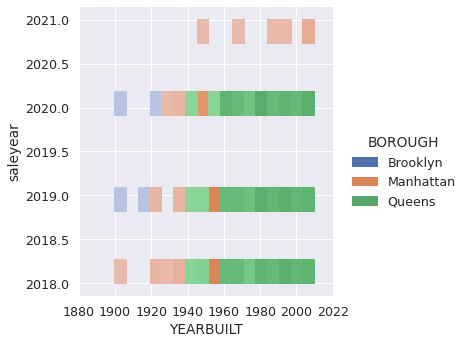

In [ ]:

dis = sns.displot(data = yearbuilt_sp, x="YEARBUILT", y="saleyear", hue="BOROUGH", aspect = 1)
dis.set_xticklabels(['1880','1900','1920','1940','1960','1980','2000','2022'])


dis


This heatmap demonstrates the building year preferences across each of the different sale years and Boroughs. From it, we can infer that during 2018, there was a strong demand for pre-1900s buildings in Manhattan, and for newer (post 1920s) Apartments in Queens. However, in 2019, we can infer a slight shift in preference for older Brooklyn Apartments, with a steady demand for Queen's newer apartments. The demands trends and preferences remained similar for apartments sold in 2020, but thee was a major shift in preferences for 2021. During this year, the demand was mostly for newer Manhattan apartments, while the overall demand for apartments in Brooklyn and Queens declined.

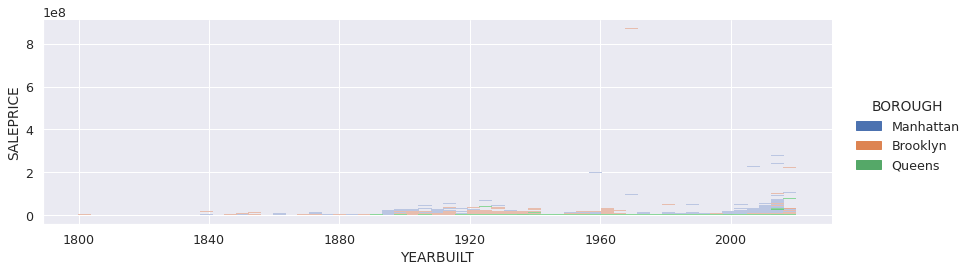

In [ ]:

dis1 = sns.displot(data = class2, x="YEARBUILT", y="SALEPRICE", hue="BOROUGH", height = 4, aspect = 3)





dis1


### Analysis:

From our analysis, we are able to understand the relationship between the year a residence was built and its sale price. As it can be seen, there is an overall positive correlation, implying that newer buildings are more expensive. However, the trend is not clear, as the sale price can be considered to be mostly steady from 1900 to 2000. However, there is a significant impact on residences built before 1900, as they were substantially cheaper, and the inverse impact with post-2000 residences, as they are substantially more expensive, across all boroughs. 

### Descriptive Question #3:

The previous descriptive questions yielded insights that Manhattan had higher frequency of having transactions compared to Brooklyn and Queens. 

To dive deeper, what is the average sale price per square feet in each of the borough's? Is there any difference between before and after the pandemic?

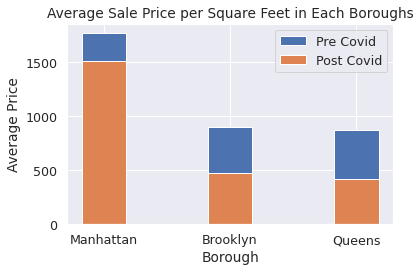

In [ ]:
class2 = nyc_db_subset.loc[nyc_db_subset['TAXCLASSATTIMEOFSALE'] == '2.0']
class2.dropna(subset = ['SALEPRICE'], inplace = True)
class2.drop(class2[class2['SALEPRICE'] == 0].index, inplace = True)
class2.dropna(subset = ['GROSSSQUAREFEET'], inplace = True)
class2.drop(class2[class2['GROSSSQUAREFEET'] == 0].index, inplace = True)



# Average Price Manhattan
class2['PRICEPERSQFT'] = class2['SALEPRICE']/class2['GROSSSQUAREFEET']
class2.dropna(subset = ['PRICEPERSQFT'], inplace = True)

class2.man = class2.loc[class2['BOROUGH'] == 'Manhattan']

class2.man.pre = class2.man.loc[class2['Pre/Post Covid'] == 'Pre Covid']
class2.man.post = class2.man.loc[class2['Pre/Post Covid'] == 'Post Covid']




manpre = class2.man.pre.PRICEPERSQFT.mean()
manpost = class2.man.post.PRICEPERSQFT.mean()

#Average Price Brooklyn
class2.bro = class2.loc[class2['BOROUGH'] == 'Brooklyn']

class2.bro.pre = class2.bro.loc[class2['Pre/Post Covid'] == 'Pre Covid']
class2.bro.post = class2.bro.loc[class2['Pre/Post Covid'] == 'Post Covid']

bropre = class2.bro.pre.PRICEPERSQFT.mean()
bropost = class2.bro.post.PRICEPERSQFT.mean()

#Average Price Queens
class2.que = class2.loc[class2['BOROUGH'] == 'Queens']

class2.que.pre = class2.que.loc[class2['Pre/Post Covid'] == 'Pre Covid']
class2.que.post = class2.que.loc[class2['Pre/Post Covid'] == 'Post Covid']

quepre = class2.que.pre.PRICEPERSQFT.mean()
quepost = class2.que.post.PRICEPERSQFT.mean()


pre = [manpre, bropre, quepre]
post = [manpost, bropost, quepost]
labels = ['Manhattan', 'Brooklyn', 'Queens']



x = np.arange(len(labels))
width=0.35
fig, ax = plt.subplots()
rects1 = ax.bar(labels, pre, width, label='Pre Covid')
rects2 = ax.bar(labels, post, width, label='Post Covid')

ax.set_ylabel('Average Price')
ax.set_xlabel('Borough')
ax.set_title('Average Sale Price per Square Feet in Each Boroughs')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()







### Analysis:

As is seen, Manhattan has the highest average sale price per square feet, followed by Brooklyn and then Queens. Moreover, the pandemic had a significant impact on the average sale price of residences in all the boroughs. Manhattan had the lowest proportional decrease, while properties in Brooklyn and Queens had a significant decrease in their prices due to the pandemic. Therefore, Brooklyn and Queens are more sensitive in pricing due to the economic impact of Covid-19. 

###Descriptive Question #4:

What is the average sale price for each of the building class categories? How does this change before/after the pandemic? 

How has the demand for NYC properties been affected by the pandemic? How has the market cap (volume of sale price) for each of the building class categories been impacted by the pandemic?





In [ ]:
# See distinct building class category with its corresponding average sale price and borough during pre/post covid
buildingclass_category = nyc_db_subset.groupby(['BUILDINGCLASSCATEGORY', 'Pre/Post Covid', 'BOROUGH'])['SALEPRICE'].mean()
buildingclass_category = buildingclass_category.to_frame()
buildingclass_category.head(30)

SALEPRICE
BUILDINGCLASSCATEGORY            Pre/Post Covid BOROUGH                
01 ONE FAMILY DWELLINGS          Post Covid     Brooklyn   7,257,142.86
                                                Manhattan 10,625,000.00
                                 Pre Covid      Brooklyn   4,388,000.00
                                                Manhattan 31,950,000.00
02 TWO FAMILY DWELLINGS          Post Covid     Brooklyn   1,428,706.47
                                                Queens       680,000.00
                                 Pre Covid      Brooklyn   1,735,646.97
                                                Manhattan  3,600,000.00
                                                Queens       763,939.00
03 THREE FAMILY DWELLINGS        Post Covid     Brooklyn   1,936,090.91
                                 Pre Covid      Brooklyn   1,050,837.22
                                                Manhattan 24,000,000.00
04 TAX CLASS 1 CONDOS            Post Covid     Brooklyn     925,118.37
                                                Manhattan  1,303,423.71
                                                Queens       578,025.66
                                 Pre Covid      Brooklyn     908,453.53
                                                Manhattan  1,841,083.76
                                                Queens       641,070.18
07 RENTALS - WALKUP APARTMENTS   Post Covid     Brooklyn   2,886,193.70
                                                Manhattan  2,369,771.25
                                                Queens     1,300,000.00
                                 Pre Covid      Brooklyn   2,686,452.82
                                                Manhattan 11,859,768.12
                                                Queens       606,666.67
08 RENTALS - ELEVATOR APARTMENTS Post Covid     Brooklyn   9,572,832.17
                                                Manhattan 11,500,000.00
                                 Pre Covid      Brooklyn  33,915,552.78
                                                Manhattan 39,600,000.00
                                                Queens    12,500,000.00
11 SPECIAL CONDO BILLING LOTS    Post Covid     Brooklyn   3,244,904.63

As it can be seen, there is a wide spread over the sale prices across the different boroughs. As it was previously discussed, the average sell price was overall higher pre-covid, and those average prices decreased with the pandemic. Furthermore,it can be seen that throughout the spread, Manhattan had -in most cases- the highest average sale price, but this differs across different building categories. For instance, the Rental- Walkup Apartments had a higher average sale price in Brooklyn than Manhattan post-covid, but before the pandemic, Manhattan was signifanctly more expensive than Brooklyn. 

In [ ]:
# Market Cap for Each Borough
buildingclass_category = nyc_db_subset.groupby(['BOROUGH'])['SALEPRICE'].sum()
buildingclass_category = buildingclass_category.to_frame()
buildingclass_category.rename(columns = {'SALEPRICE':'MARKETCAP'}, inplace = True)
buildingclass_category.head(30)

,MARKETCAP
BOROUGH,
Brooklyn,"16,034,532,374.00"
Manhattan,"52,665,298,568.00"
Queens,"7,715,451,312.00"


As it can be seen, Manhattan has the highest market cap, for which we can assume it was the Borough that the most money transacted during the period of analysis, followed by Brooklyn and finally Queens. However, has the pandemic had any impact on the market cap in each of the boroughs?

In [ ]:
# Find Market Cap for each Borough pre/post Covid
buildingclass_category = nyc_db_subset.groupby(['BOROUGH', 'Pre/Post Covid'])['SALEPRICE'].sum()
buildingclass_category = buildingclass_category.to_frame()
buildingclass_category.rename(columns = {'SALEPRICE':'MARKETCAP'}, inplace = True)
# buildingclass_category['MARKETCAP']= buildingclass_category['MARKETCAP'].astype("string")
# buildingclass_category['MARKETCAP'] = buildingclass_category['MARKETCAP'].str.rstrip("%").astype(float)/100
# buildingclass_category['MARKETCAP'].pct_change()

# look at pct change again
buildingclass_category

MARKETCAP
BOROUGH   Pre/Post Covid                  
Brooklyn  Post Covid      4,685,444,361.00
          Pre Covid      11,349,088,013.00
Manhattan Post Covid     15,994,125,599.00
          Pre Covid      36,671,172,969.00
Queens    Post Covid      3,138,186,700.00
          Pre Covid       4,577,264,612.00

As it can be seen, the pandemic had an immense impact of the market cap. However, each borough was affected to a different extent. In absolute value, Manhattan was the most affected by the pandemic, followed by Brooklyn and finally Queens. However, in the percent change, Brooklyn was the most affected, followed by Manhattan and then Queens. 

In [ ]:
# See distinct building class category with its corresponding market cap and borough during pre/post covid
buildingclass_category = nyc_db_subset.groupby(['BUILDINGCLASSCATEGORY', 'Pre/Post Covid', 'BOROUGH'])['SALEPRICE'].sum()
buildingclass_category = buildingclass_category.to_frame()
buildingclass_category.rename(columns = {'SALEPRICE':'MARKETCAP'}, inplace = True)
buildingclass_category.head(30)

MARKETCAP
BUILDINGCLASSCATEGORY            Pre/Post Covid BOROUGH                   
01 ONE FAMILY DWELLINGS          Post Covid     Brooklyn     50,800,000.00
                                                Manhattan    10,625,000.00
                                 Pre Covid      Brooklyn     21,940,000.00
                                                Manhattan    31,950,000.00
02 TWO FAMILY DWELLINGS          Post Covid     Brooklyn     24,288,010.00
                                                Queens          680,000.00
                                 Pre Covid      Brooklyn     57,276,350.00
                                                Manhattan     3,600,000.00
                                                Queens          763,939.00
03 THREE FAMILY DWELLINGS        Post Covid     Brooklyn     21,297,000.00
                                 Pre Covid      Brooklyn     43,084,326.00
                                                Manhattan    24,000,000.00
04 TAX CLASS 1 CONDOS            Post Covid     Brooklyn    245,156,367.00
                                                Manhattan     9,123,966.00
                                                Queens       50,866,258.00
                                 Pre Covid      Brooklyn    556,882,013.00
                                                Manhattan    31,298,424.00
                                                Queens      150,651,492.00
07 RENTALS - WALKUP APARTMENTS   Post Covid     Brooklyn    311,708,920.00
                                                Manhattan     9,479,085.00
                                                Queens        1,300,000.00
                                 Pre Covid      Brooklyn    988,614,639.00
                                                Manhattan   189,756,290.00
                                                Queens        1,820,000.00
08 RENTALS - ELEVATOR APARTMENTS Post Covid     Brooklyn    172,310,979.00
                                                Manhattan    11,500,000.00
                                 Pre Covid      Brooklyn  1,695,777,639.00
                                                Manhattan    79,200,000.00
                                                Queens       12,500,000.00
11 SPECIAL CONDO BILLING LOTS    Post Covid     Brooklyn  1,031,879,672.00

We decided that for our analysis, it would also be relevant to understand the market cap in each of the boroughs. To identify it, we added all the transacion prices by building category across each borough, and then distinguished between pre and post covid. Therefore, the values represent the sum of the total sale prices, to understand the different patterns of demand. In this case, we can see that Brooklyn had the most market movements, as more money was transacted in that Borough. \

In [ ]:
# See the residential building class at time of sale 'A' with its borough during both pre/post Covid

buildingclass_ts = nyc_db_subset[nyc_db_subset['BUILDINGCLASSATTIMEOFSALE'].str.startswith('A')]
buildingclass_ts = buildingclass_ts.groupby(['BOROUGH', 'BUILDINGCLASSATTIMEOFSALE', 'Pre/Post Covid'])['SALEPRICE'].nunique()
buildingclass_ts = buildingclass_ts.to_frame()
buildingclass_ts.rename(columns = {'SALEPRICE':'# of Transactions'}, inplace = True)
buildingclass_ts.head(94)


# of Transactions
BOROUGH   BUILDINGCLASSATTIMEOFSALE Pre/Post Covid                   
Brooklyn  A4                        Post Covid                      3
                                    Pre Covid                       3
          A5                        Post Covid                      2
                                    Pre Covid                       1
          A7                        Post Covid                      1
          A9                        Post Covid                      1
Manhattan A4                        Post Covid                      1
          A7                        Pre Covid                       1

### Analysis:

Finally, it would be relevant to understand how the number of transactions vary across building classes and the impact of the pandemic. In this case, we are more concerned about the amount of sales, rather than the sale price, since we can have a better perspective of the market movements.

###**Regression Analysis**

As part of our analysis, we try to identify which of the variables from the dataset has the greatest impact on the sales price. Therefore, we will run a multivariate regression, including jousing factors such as 


*   gross square feet
*   building class category (e.g one family, multi family, etc)
*   tax class at time sale: class '2' (residential property)
*   building class at time of sale 'A' (one-family home) 
* Borough





We would like to understand how each of those variables change across Boroughs and the impact of the pandemic. 

In [ ]:
# Run regression for Pre-Covid Variables

regpre = nyc_db_subset[nyc_db_subset['BUILDINGCLASSATTIMEOFSALE'].str.startswith('A')]
regpre = nyc_db_subset[nyc_db_subset['TAXCLASSATTIMEOFSALE'] == '2.0']
regpre = nyc_db_subset[nyc_db_subset['Pre/Post Covid'] == 'Pre Covid']
regspre = smf.ols(data= regpre, formula='SALEPRICE ~ GROSSSQUAREFEET + BOROUGH+ BUILDINGCLASSATTIMEOFSALE').fit()
regspre.summary()





<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SALEPRICE   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     57.16
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:48:01   Log-Likelihood:            -3.6792e+05
No. Observations:               20283   AIC:                         7.359e+05
Df Residuals:                   20234   BIC:                         7.363e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        3.585e+06   1.06e+07      0.340      0.734   -1.71e+07    2.43e+07
BOROUGH[T.Manhattan]             2.474e+06   3.25e+05      7.619      0.000    1.84e+06    3.11e+06
BOROUGH[T.Queens]               -5.769e+05   3.92e+05     -1.473      0.141   -1.34e+06    1.91e+05
BUILDINGCLASSATTIMEOFSALE[T.A5] -2.287e+06   2.11e+07     -0.108      0.914   -4.37e+07    3.91e+07
BUILDINGCLASSATTIMEOFSALE[T.A7]  2.018e+07   2.11e+07      0.955      0.339   -2.12e+07    6.16e+07
BUILDINGCLASSATTIMEOFSALE[T.B1] -3.246e+06   1.16e+07     -0.279      0.780   -2.61e+07    1.96e+07
BUILDINGCLASSATTIMEOFSALE[T.B2] -3.827e+06   1.67e+07     -0.229      0.819   -3.66e+07    2.89e+07
BUILDINGCLASSATTIMEOFSALE[T.B3] -2.397e+06    1.4e+07     -0.172      0.864   -2.98e+07     2.5e+07
BUILDINGCLASSATTIMEOFSALE[T.B9] -4.092e+06    1.2e+07     -0.340      0.734   -2.77e+07    1.95e+07
BUILDINGCLASSATTIMEOFSALE[T.C0] -4.185e+06   1.09e+07     -0.383      0.702   -2.56e+07    1.72e+07
BUILDINGCLASSATTIMEOFSALE[T.C1] -7.531e+06   1.07e+07     -0.705      0.481   -2.85e+07    1.34e+07
BUILDINGCLASSATTIMEOFSALE[T.C2] -4.015e+06   1.07e+07     -0.374      0.708   -2.51e+07     1.7e+07
BUILDINGCLASSATTIMEOFSALE[T.C3] -4.207e+06   1.07e+07     -0.394      0.693   -2.51e+07    1.67e+07
BUILDINGCLASSATTIMEOFSALE[T.C4] -2.915e+05    1.4e+07     -0.021      0.983   -2.77e+07    2.71e+07
BUILDINGCLASSATTIMEOFSALE[T.C5]  -4.07e+05   1.29e+07     -0.031      0.975   -2.58e+07    2.49e+07
BUILDINGCLASSATTIMEOFSALE[T.C7] -5.277e+06   1.16e+07     -0.456      0.648    -2.8e+07    1.74e+07
BUILDINGCLASSATTIMEOFSALE[T.D1] -2.437e+07    1.1e+07     -2.221      0.026   -4.59e+07   -2.86e+06
BUILDINGCLASSATTIMEOFSALE[T.D3]   5.68e+07   1.46e+07      3.882      0.000    2.81e+07    8.55e+07
BUILDINGCLASSATTIMEOFSALE[T.D7] -2.033e+07    1.3e+07     -1.564      0.118   -4.58e+07    5.14e+06
BUILDINGCLASSATTIMEOFSALE[T.D9]  1.113e+07   1.67e+07      0.667      0.505   -2.16e+07    4.39e+07
BUILDINGCLASSATTIMEOFSALE[T.H9]  -1.18e+07   2.11e+07     -0.559      0.576   -5.32e+07    2.96e+07
BUILDINGCLASSATTIMEOFSALE[T.HR]  -4.49e+06   2.11e+07     -0.213      0.832   -4.59e+07    3.69e+07
BUILDINGCLASSATTIMEOFSALE[T.K4] -4.068e+06   2.11e+07     -0.193      0.847   -4.55e+07    3.73e+07
BUILDINGCLASSATTIMEOFSALE[T.M1] -4.202e+06   1.67e+07     -0.252      0.801   -3.69e+07    2.85e+07
BUILDINGCLASSATTIMEOFSALE[T.R1] -2.841e+06   1.06e+07     -0.269      0.788   -2.36e+07    1.79e+07
BUILDINGCLASSATTIMEOFSALE[T.R2] -2.958e+06   1.06e+07     -0.280      0.780   -2.37e+07    1.78e+07
BUILDINGCLASSATTIMEOFSALE[T.R3] -3.069e+06   1.06e+07     -0.290      0.772   -2.38e+07    1.77e+07
BUILDINGCLASSATTIMEOFSALE[T.R4] -3.067e+06   1.06e+07     -0.290      0.772   -2.38

When running the regression for the impact the variables had on the sales price before the pandemic, the overall correlation was low, at 0.119. Individually, each of the variables, had a low correlation -possibly due to the amount of variables included, but all which are highly relevant for our analysis. Furthemore, the correlation coefficients for most of the buildings categories is negative, except for A7, D3, D9, R5, RA, RB, RH and RK, most of which are Condos. Based on the p-values (lower than 0.05), we can see that building classes C4 and C5, which are both Walk Up Apartments, are the only ones significant. As expected, Borough and Gross Square Feet had a much higher correlation with Sale Price, as an increase of one unit in Gross Square Feet, would represent a $606 increase in sale price. On the other hand, Borough didn't seem to have such a strong correlation either, possibly due to the range of prices or high amount of variables being explored. 

In [ ]:
# Test Regression for Post-Covid Variables
regpost = nyc_db_subset[nyc_db_subset['BUILDINGCLASSATTIMEOFSALE'].str.startswith('A')]
regpost = nyc_db_subset[nyc_db_subset['TAXCLASSATTIMEOFSALE'] == '2.0']
regpost = nyc_db_subset[nyc_db_subset['Pre/Post Covid'] == 'Post Covid']
regspost = smf.ols(data= regpost, formula='SALEPRICE ~ GROSSSQUAREFEET + BOROUGH + BUILDINGCLASSCATEGORY').fit()
regspost.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SALEPRICE   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     57.63
Date:                Fri, 09 Dec 2022   Prob (F-statistic):          2.46e-256
Time:                        20:48:01   Log-Likelihood:            -1.5360e+05
No. Observations:                8646   AIC:                         3.072e+05
Df Residuals:                    8621   BIC:                         3.074e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            7.364e+06   4.45e+06      1.656      0.098   -1.36e+06    1.61e+07
BOROUGH[T.Manhattan]                                                  2.68e+06   3.56e+05      7.537      0.000    1.98e+06    3.38e+06
BOROUGH[T.Queens]                                                   -5.519e+04    3.9e+05     -0.142      0.887    -8.2e+05    7.09e+05
BUILDINGCLASSCATEGORY[T.02 TWO FAMILY DWELLINGS]                    -5.963e+06   5.35e+06     -1.115      0.265   -1.64e+07    4.52e+06
BUILDINGCLASSCATEGORY[T.03 THREE FAMILY DWELLINGS]                  -5.414e+06   5.85e+06     -0.926      0.354   -1.69e+07    6.05e+06
BUILDINGCLASSCATEGORY[T.04 TAX CLASS 1 CONDOS]                      -6.555e+06    4.5e+06     -1.457      0.145   -1.54e+07    2.26e+06
BUILDINGCLASSCATEGORY[T.07 RENTALS - WALKUP APARTMENTS]             -4.568e+06    4.6e+06     -0.992      0.321   -1.36e+07    4.45e+06
BUILDINGCLASSCATEGORY[T.08 RENTALS - ELEVATOR APARTMENTS]            2.499e+06   5.31e+06      0.471      0.638    -7.9e+06    1.29e+07
BUILDINGCLASSCATEGORY[T.11 SPECIAL CONDO BILLING LOTS]              -2.447e+06   4.56e+06     -0.537      0.592   -1.14e+07    6.49e+06
BUILDINGCLASSCATEGORY[T.12 CONDOS - WALKUP APARTMENTS]              -6.706e+06   4.49e+06     -1.493      0.136   -1.55e+07     2.1e+06
BUILDINGCLASSCATEGORY[T.13 CONDOS - ELEVATOR APARTMENTS]            -6.581e+06   4.46e+06     -1.477      0.140   -1.53e+07    2.15e+06
BUILDINGCLASSCATEGORY[T.14 RENTALS - 4-10 UNIT]                     -2.599e+06   5.14e+06     -0.506      0.613   -1.27e+07    7.47e+06
BUILDINGCLASSCATEGORY[T.15 CONDOS - 2-10 UNIT RESIDENTIAL]          -6.438e+06   4.47e+06     -1.442      0.149   -1.52e+07    2.32e+06
BUILDINGCLASSCATEGORY[T.16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT] -5.737e+06   4.88e+06     -1.175      0.240   -1.53e+07    3.84e+06
BUILDINGCLASSCATEGORY[T.28 COMMERCIAL CONDOS]                       -3.239e+06   5.35e+06     -0.606      0.545   -1.37e+07    7.24e+06
BUILDINGCLASSCATEGORY[T.33 EDUCATIONAL FACILITIES]                  -4.057e+06   1.33e+07     -0.304      0.761   -3.02e+07    2.21e+07
BUILDINGCLASSCATEGORY[T.42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC]   1.667e+06   5.51e+06      0.302      0.762   -9.14e+06    1.25e+07
BUILDINGCLASSCATEGORY[T.43 CONDO OFFICE BUILDINGS]                   2.551e+07   4.58e+06      5.570      0.000    1.65e+07    3.45e+07
BUILDINGCLASSCATEGORY[T.44 CONDO PARKING]                           -6.447e+06   4.48e+06     -1.439      0.150   -1.52e+07    2.33e+06
BUILDINGCLASSCATEGORY[T.45 CONDO HOTELS]                             3.653e+07   5.07e+06  

However, when analyzing the impact that the pandemic had on influecing the variables that impact sale price, the results were very similar. The overall correlation, although a bit higher at 0.138. Nevertheless, based on the p-values, none of the variables are statistically significant, which is once again likely due to the high amount of "x" variables that we chose in the regression. Possibly the main difference of the regression is the impact that gross square feet had in the prices. In this case, the correlation coefficient is negative, indicating an inverse relationship.

**Correlation between Sale Price and Gross Square Feet**

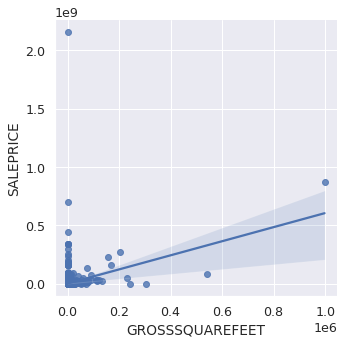

In [ ]:
# Correlation Before Pandemic
sns.lmplot(x="GROSSSQUAREFEET",
           y="SALEPRICE", 
           data=regpre);

As it was previously discussed, before the pandemic, a higher gross square feet was relevant when determining the sale price, as it can be seen by the graph.

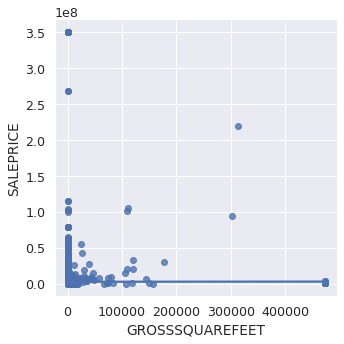

In [ ]:
# Correlation Before Pandemic
sns.lmplot(x="GROSSSQUAREFEET",
           y="SALEPRICE", 
           data=regpost);

On the other hand, after the pandemic, the correlation diminishes, and gross square feet is no longer a significant determinant. 

# **Supervised Learning**

### Visualization is a great place to start: 
###plot each of the variables to understand how they change over time and relate to each other

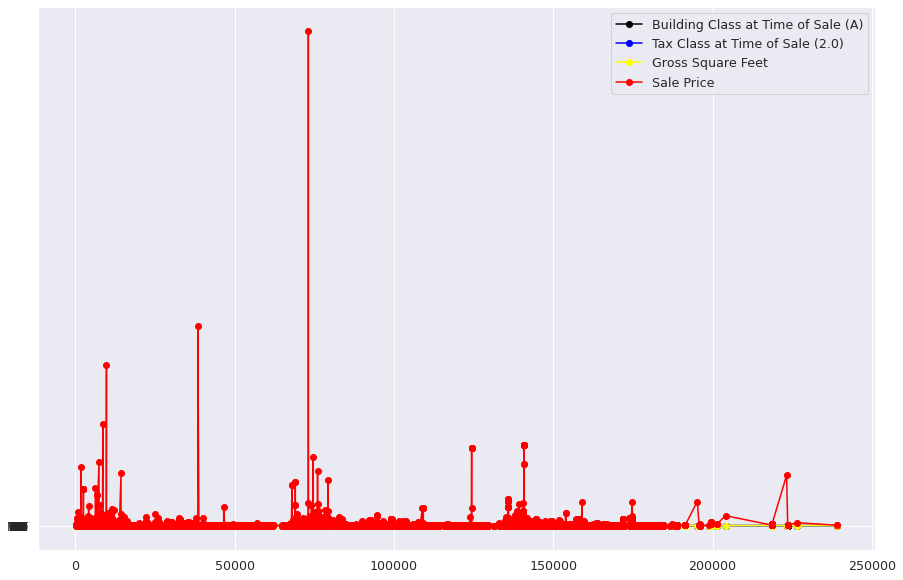

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(nyc_db_subset['BUILDINGCLASSATTIMEOFSALE'], marker='o', color='black', label = 'Building Class at Time of Sale (A)')
plt.plot(nyc_db_subset['TAXCLASSATTIMEOFSALE'], marker='o', color='blue', label = 'Tax Class at Time of Sale (2.0)')
plt.plot(nyc_db_subset['GROSSSQUAREFEET'], marker='o', color='yellow', label = 'Gross Square Feet')
plt.plot(nyc_db_subset['SALEPRICE'], marker='o', color='red', label = 'Sale Price')

plt.legend()

### Forecasting from Supervised Learning Method

In [ ]:
# 
nyc_db_subset.tail()

,BOROUGH,NEIGHBORHOOD,BUILDINGCLASSCATEGORY,BLOCK,LOT,ADDRESS,APARTMENTNUMBER,ZIPCODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTALUNITS,LANDSQUAREFEET,GROSSSQUAREFEET,YEARBUILT,TAXCLASSATTIMEOFSALE,BUILDINGCLASSATTIMEOFSALE,SALEPRICE,SALEDATE,saleyear,Pre/Post Covid
223738,Brooklyn,DOWNTOWN-FULTON MALL,11 SPECIAL CONDO BILLING LOTS,149.0,1102.0,"138 WILLOUGHBY STREET, 68C",RESI,11201.0,458.00,0.00,458.00,"21,474.00","472,115.00",2017-01-01,2.0,RR,"2,643,434.00",2021-03-11,2021,Post Covid
223739,Brooklyn,DOWNTOWN-FULTON MALL,11 SPECIAL CONDO BILLING LOTS,149.0,1102.0,"138 WILLOUGHBY STREET, 68H",RESI,11201.0,458.00,0.00,458.00,"21,474.00","472,115.00",2017-01-01,2.0,RR,"2,625,994.00",2021-10-07,2021,Post Covid
226481,Brooklyn,FLATBUSH-CENTRAL,11 SPECIAL CONDO BILLING LOTS,5141.0,1102.0,"1027 CORTELYOU ROAD, R1",R1,11218.0,11.00,0.00,11.00,"5,111.00","13,744.00",2019-01-01,2.0,RR,"12,835,000.00",2021-12-21,2021,Post Covid
238910,Brooklyn,WILLIAMSBURG-EAST,11 SPECIAL CONDO BILLING LOTS,2765.0,1007.0,"764 METROPOLITAN AVENUE, 4A",4A,11211.0,1.00,0.00,1.00,0.00,"1,460.00",2015-01-01,2.0,RR,"1,612,500.00",2021-06-07,2021,Post Covid
238911,Brooklyn,WILLIAMSBURG-EAST,11 SPECIAL CONDO BILLING LOTS,2765.0,1010.0,"764 METROPOLITAN AVENUE, PHB",PHB,11211.0,1.00,0.00,1.00,0.00,793.00,2015-01-01,2.0,RR,"1,062,500.00",2021-07-26,2021,Post Covid


In [ ]:
# add into final dataframe
extra = nyc_db_subset = pd.Dataframe({'saleyear :  [2023, 2024, 2025]'})
extra = nyc_db_subset.append(extra, ignore_index = True)
extra.tail()

AttributeError: ignored

In [ ]:
# Create OLS based forecast
# use model.predict() to calculate prediced Y values

extra['SALEPRICE'] = model.predict(extra['saleyear'])

In [ ]:
# plot the outsample forecast

plt.figure(figsize=(15, 6))
plt.plot(cokeq[variable], marker='o', color='black', label = 'Actual Demand')
plt.plot(cokeq['ols_prediction'], marker='o', color='orange', label = 'OLS Prediction')

plt.legend()
plt.ylabel(variable)
plt.xlabel('Time Period')

### Forecasting Analysis:



### Overarching Question & Overall Analysis

Overall, the purpose of our analysis was to determine the impact that the pandemic had on the preferences, trends and sale price of NYC residences. In order to do so, our analysis consisted of 4 descriptive questions, each that provided insight for our overall conclusion. The first question attempted to understand the distribution of demand across the boroughs, and the impact that the pandemic had on it. As it was previously commented, Manhattan absorped most of the demand overall, followed by Brooklyn and Queens. In addition, it was also evident that the overall demand fell substantially, from 71% of transactions occurring before the pandemic, and 29% after it.

In our second question, we tried to identify the relationship between year built, demand and sale price. Our analysis revealed when were the residences built in each Borough, as well as which types of buildings (new or old) were preferred in each borough in each year. Furthermore, we identified the impact that the variable "YEARBUILT" has on price, and the results have been previously discussed.

We continued our analysis by trying to understand the impact of the pandemic on the average price per square foot, where we were able to identify not only which borough had the highest average, but also which one was the most impacted by the pandemic. 

Finally, we focused on the building class category of the NYC residences, and how each of their prices varies across borough and pre/post covid. We then calculated the market cap, to understand the demand each of the building class categories had, and how many transactions had been made pre/post covid to potentially analyze any shifts in demand. To have a clearer idea about any potential shifts in demand, we also calculated the # of transactions in each Borough for each building class category.

For our regression analysis, we ran a regression with the previously identified variables and sale price. Our result yielded that most variables weren't statistically significant, for which we chose to run a separate regression just for Gross Square Feet. By doing so, we were able to understand that before the pandemic, gross square feet had much stronger relationship with sale price than after the pandemic.